In [6]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import os
from PIL import Image
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# --- 1. Configuración Inicial ---
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# AJUSTA ESTAS RUTAS Y PARÁMETROS
TRAIN_IMG_DIR = 'modelo_yolov11_dataset_completo/train/images'
TRAIN_ANN_FILE = 'modelo_yolov11_dataset_completo/train/train_coco.json'
VAL_IMG_DIR = 'modelo_yolov11_dataset_completo/val/images'
VAL_ANN_FILE = 'modelo_yolov11_dataset_completo/val/val_coco.json'

NUM_EPOCHS = 3
BATCH_SIZE = 4
LEARNING_RATE = 0.005

# --- Auto-configuración de Clases (basado en el archivo de validación) ---
coco_val_for_config = COCO(VAL_ANN_FILE)
coco_categories = coco_val_for_config.loadCats(coco_val_for_config.getCatIds())
CLASS_NAMES_COCO = {cat['id']: cat['name'] for cat in coco_categories}
COCO_ID_TO_MODEL_ID = {cat_id: i + 1 for i, cat_id in enumerate(sorted(CLASS_NAMES_COCO.keys()))}
MODEL_ID_TO_COCO_ID = {model_id: coco_id for coco_id, model_id in COCO_ID_TO_MODEL_ID.items()}
NUM_MODEL_CLASSES = len(CLASS_NAMES_COCO) + 1

print(f"--- Configuración de Clases ---")
print(f"Clases detectadas en COCO (ID_COCO: Nombre): {CLASS_NAMES_COCO}")
print(f"Mapeo COCO ID -> Modelo ID: {COCO_ID_TO_MODEL_ID}")
print(f"Número de clases para el modelo (incl. background): {NUM_MODEL_CLASSES}")
print(f"Usando dispositivo: {DEVICE}")
print(f"-------------------------------")

# --- 2. Dataset Personalizado ---
class MineriaDataset(Dataset):
    def __init__(self, img_dir, ann_file, transforms=None):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms
        self.coco_to_model_id_map = COCO_ID_TO_MODEL_ID

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        coco_annotations = self.coco.loadAnns(ann_ids)

        path = self.coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.img_dir, path)).convert('RGB')

        boxes_list = []
        labels_list = []
        areas_list = []
        iscrowd_list = []


        for ann in coco_annotations:
            xmin, ymin, width, height = ann['bbox']
            boxes_list.append([xmin, ymin, xmin + width, ymin + height])
            labels_list.append(self.coco_to_model_id_map[ann['category_id']])
            areas_list.append(ann['area'])
            iscrowd_list.append(ann['iscrowd'])

        target = {}
        if not coco_annotations:
            target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
            target["labels"] = torch.zeros(0, dtype=torch.int64)
            target["area"] = torch.zeros(0, dtype=torch.float32)
            target["iscrowd"] = torch.zeros(0, dtype=torch.int64)
        else:
            target["boxes"] = torch.as_tensor(boxes_list, dtype=torch.float32)
            target["labels"] = torch.as_tensor(labels_list, dtype=torch.int64)
            target["area"] = torch.as_tensor(areas_list, dtype=torch.float32)
            target["iscrowd"] = torch.as_tensor(iscrowd_list, dtype=torch.int64)

        target["image_id"] = torch.tensor([img_id])

        if self.transforms:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.ids)

# --- 3. Transformaciones ---
# --- 3. Transformaciones (CORREGIDA) ---
def get_transform(train):
    transforms_list = []
    transforms_list.append(T.ToImage())
    transforms_list.append(T.ToDtype(torch.float, scale=True))

    if train:
        transforms_list.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms_list)

# --- 4. Modelo Faster R-CNN ---
def get_model(num_model_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_model_classes)
    return model

# --- 5. Collate Function (para DataLoader)---
def collate_fn(batch):
    return tuple(zip(*batch))

# --- 6. Entrenamiento ---
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()

    progress_bar = tqdm(data_loader, desc=f"Epoch [{epoch}] Training", leave=True, ncols=100)

    total_loss_epoch = 0.0
    num_batches = 0

    for i, (images, targets) in enumerate(progress_bar):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        current_loss = losses.item()
        total_loss_epoch += current_loss
        num_batches += 1
        
        progress_bar.set_postfix(loss=f"{current_loss:.4f}", avg_loss_epoch=f"{total_loss_epoch/num_batches:.4f}")

# --- 7. Evaluación COCO mAP ---
@torch.no_grad()
def evaluate_coco_map(model, data_loader, device, coco_gt_obj):
    model.eval()
    coco_results = []
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]

        for target, output in zip(targets, outputs):
            img_id = target["image_id"].item()
            for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
                coco_cat_id = MODEL_ID_TO_COCO_ID[label.item()]
                coco_results.append({
                    "image_id": img_id,
                    "category_id": coco_cat_id,
                    "bbox": [box[0].item(), box[1].item(), (box[2]-box[0]).item(), (box[3]-box[1]).item()], #x,y,w,h
                    "score": score.item(),
                })
    if not coco_results:
        print("No se generaron predicciones para la evaluación COCO.")
        return None

    coco_dt = coco_gt_obj.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt_obj, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    print("\n--- Resultados de Evaluación COCO mAP ---")
    coco_eval.summarize()
    return coco_eval

# --- 8. Precisión y Recall por Clase ---
@torch.no_grad()
def calculate_per_class_metrics(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    class_predictions = {model_id: {'scores': [], 'is_tp': []} for model_id in MODEL_ID_TO_COCO_ID.keys()}
    class_gt_counts = {model_id: 0 for model_id in MODEL_ID_TO_COCO_ID.keys()}


    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i in range(len(targets)): # Por cada imagen
            gt_boxes = targets[i]['boxes'].cpu()
            gt_labels = targets[i]['labels'].cpu()
            pred_boxes = outputs[i]['boxes'].cpu()
            pred_labels = outputs[i]['labels'].cpu()
            pred_scores = outputs[i]['scores'].cpu()

            # Contar GTs por clase (del modelo)
            for gt_label in gt_labels:
                class_gt_counts[gt_label.item()] += 1

            # Match predicciones con GTs
            if pred_boxes.shape[0] == 0: continue

            for model_cls_id in MODEL_ID_TO_COCO_ID.keys():
                gt_mask = (gt_labels == model_cls_id)
                pred_mask = (pred_labels == model_cls_id)

                current_gt_boxes = gt_boxes[gt_mask]
                current_pred_boxes = pred_boxes[pred_mask]
                current_pred_scores = pred_scores[pred_mask]

                if current_pred_boxes.shape[0] == 0: continue

                # Ordenar predicciones por score
                sorted_indices = torch.argsort(current_pred_scores, descending=True)
                current_pred_boxes = current_pred_boxes[sorted_indices]
                current_pred_scores = current_pred_scores[sorted_indices]

                is_tp = torch.zeros(current_pred_boxes.shape[0], dtype=torch.bool)
                gt_matched = torch.zeros(current_gt_boxes.shape[0], dtype=torch.bool)

                if current_gt_boxes.shape[0] > 0:
                    overlaps = torchvision.ops.box_iou(current_pred_boxes, current_gt_boxes)
                    for pred_idx in range(current_pred_boxes.shape[0]):
                        max_iou_for_pred, gt_match_idx = -1.0, -1
                        if overlaps.shape[1] > 0: # Si hay GTs para esta clase
                             max_iou_val, best_gt_idx = overlaps[pred_idx].max(dim=0)
                             if max_iou_val >= iou_threshold and not gt_matched[best_gt_idx]:
                                max_iou_for_pred = max_iou_val
                                gt_match_idx = best_gt_idx

                        if gt_match_idx != -1:
                            is_tp[pred_idx] = True
                            gt_matched[gt_match_idx] = True
                
                class_predictions[model_cls_id]['scores'].extend(current_pred_scores.tolist())
                class_predictions[model_cls_id]['is_tp'].extend(is_tp.tolist())

    print(f"\n--- Métricas por Clase (IoU Thresh={iou_threshold}) ---")
    avg_precisions = []
    for model_cls_id, data in class_predictions.items():
        coco_cls_id = MODEL_ID_TO_COCO_ID[model_cls_id]
        class_name = CLASS_NAMES_COCO[coco_cls_id]
        
        scores = np.array(data['scores'])
        is_tp = np.array(data['is_tp'], dtype=np.float64) # Para AP, y_true es 1 si TP, 0 si FP

        if len(scores) == 0:
            ap = 0.0
            precision = 0.0
            recall = 0.0
            if class_gt_counts[model_cls_id] == 0: # No GTs, no preds
                ap = 1.0 # O Nan/skip
                precision = 1.0
                recall = 1.0
        else:
            # Calcular AP usando sklearn
            ap = average_precision_score(is_tp, scores) if sum(is_tp) > 0 else 0.0
            
            num_tp = np.sum(is_tp)
            num_pred = len(scores)
            num_gt = class_gt_counts[model_cls_id]

            precision = num_tp / num_pred if num_pred > 0 else 0.0
            recall = num_tp / num_gt if num_gt > 0 else 0.0
            if num_gt == 0 and num_pred == 0:
                precision = 1.0
                recall = 1.0
            elif num_gt == 0 and num_pred > 0:
                 recall = 1.0

        avg_precisions.append(ap)
        print(f"Clase: '{class_name}' (COCO ID: {coco_cls_id}, Modelo ID: {model_cls_id})")
        print(f"  AP (sklearn): {ap:.4f}")
        print(f"  Precisión:    {precision:.4f} (TPs: {int(np.sum(is_tp))}, Preds: {len(scores)})")
        print(f"  Recall:       {recall:.4f} (TPs: {int(np.sum(is_tp))}, GTs: {class_gt_counts[model_cls_id]})")
    
    if avg_precisions:
        mean_ap_sklearn = np.mean([ap for ap in avg_precisions if not np.isnan(ap)]) # Ignorar NaN si alguna clase no tuvo GTs y dio AP=1 o similar
        print(f"\nmAP (calculado con sklearn sobre clases evaluadas): {mean_ap_sklearn:.4f}")


# --- 9. Flujo Principal ---
if __name__ == '__main__':
    # Verificar si las rutas existen
    if not os.path.isdir(TRAIN_IMG_DIR) or not os.path.isfile(TRAIN_ANN_FILE):
        print(f"Error: Ruta de entrenamiento no encontrada. Verifica TRAIN_IMG_DIR y TRAIN_ANN_FILE.")
        exit()
    if not os.path.isdir(VAL_IMG_DIR) or not os.path.isfile(VAL_ANN_FILE):
        print(f"Error: Ruta de validación no encontrada. Verifica VAL_IMG_DIR y VAL_ANN_FILE.")
        exit()
    if not CLASS_NAMES_COCO:
        print(f"Error: No se pudieron cargar las categorías del archivo de anotaciones de validación: {VAL_ANN_FILE}")
        exit()


    # Datasets y DataLoaders
    dataset_train = MineriaDataset(TRAIN_IMG_DIR, TRAIN_ANN_FILE, transforms=get_transform(train=True))
    dataset_val = MineriaDataset(VAL_IMG_DIR, VAL_ANN_FILE, transforms=get_transform(train=False))

    effective_batch_size_train = min(BATCH_SIZE, len(dataset_train))
    effective_batch_size_val = 1 # Para evaluación, suele ser 1

    if len(dataset_train) == 0 or len(dataset_val) == 0:
        print("Error: Uno de los datasets está vacío. Verifica tus archivos de anotaciones y rutas.")
        exit()
    if effective_batch_size_train == 0:
        print("Error: El tamaño del batch de entrenamiento es 0. Probablemente el dataset de entrenamiento está vacío.")
        exit()

    data_loader_train = DataLoader(dataset_train, batch_size=effective_batch_size_train, shuffle=True,
                                   num_workers=0, collate_fn=collate_fn) # Reduce num_workers si tienes problemas
    data_loader_val = DataLoader(dataset_val, batch_size=effective_batch_size_val, shuffle=False,
                                 num_workers=2, collate_fn=collate_fn)

    print(f"Dataset de entrenamiento: {len(dataset_train)} imágenes. DataLoader batch size: {effective_batch_size_train}")
    print(f"Dataset de validación: {len(dataset_val)} imágenes. DataLoader batch size: {effective_batch_size_val}")


    # Modelo, Optimizador
    model = get_model(NUM_MODEL_CLASSES)
    model.to(DEVICE)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
    # Un scheduler simple (opcional, pero ayuda)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=max(1, NUM_EPOCHS // 3), gamma=0.1)


    print("\n--- Iniciando Entrenamiento ---")
    for epoch in range(NUM_EPOCHS):
        train_one_epoch(model, optimizer, data_loader_train, DEVICE, epoch)
        lr_scheduler.step()

        # Evaluación COCO mAP al final de cada época
        print(f"\n--- Evaluación COCO mAP después de la Época {epoch} ---")
        coco_eval_results = evaluate_coco_map(model, data_loader_val, device=DEVICE, coco_gt_obj=dataset_val.coco)

    print("\n--- Entrenamiento Finalizado ---")

    # Guardar el modelo
    model_save_path = 'fasterrcnn_mineria_final.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"Modelo guardado en: {model_save_path}")

    # Calcular y mostrar métricas finales de Precisión, Recall y AP por clase
    calculate_per_class_metrics(model, data_loader_val, DEVICE)

    if coco_eval_results:
        print("\n--- Resumen Final Métricas COCO mAP (de la última época) ---")
        # coco_eval_results.summarize() # Ya se imprimió antes
        print(f"mAP (IoU=0.50:0.95): {coco_eval_results.stats[0]:.4f}")
        print(f"mAP (IoU=0.50): {coco_eval_results.stats[1]:.4f}")
    else:
        print("No hay resultados de COCOeval disponibles para el resumen final.")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
--- Configuración de Clases ---
Clases detectadas en COCO (ID_COCO: Nombre): {0: 'Vehiculos', 1: 'Bodegas', 2: 'Caminos', 3: 'Rios', 4: 'Zonas de mineria ilegal'}
Mapeo COCO ID -> Modelo ID: {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}
Número de clases para el modelo (incl. background): 6
Usando dispositivo: cuda
-------------------------------
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Dataset de entrenamiento: 8233 imágenes. DataLoader batch size: 4
Dataset de validación: 984 imágenes. DataLoader batch size: 1

--- Iniciando Entrenamiento ---


Epoch [0] Training:   2%|   | 50/2059 [07:56<5:19:19,  9.54s/it, avg_loss_epoch=0.3511, loss=0.1836]


KeyboardInterrupt: 

In [16]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader, Dataset, Subset # <--- AÑADE SUBSET
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import os
from PIL import Image
from sklearn.metrics import average_precision_score
from tqdm import tqdm
import random # Para muestreo aleatorio si se desea

# --- 1. Configuración Inicial ---
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
TRAIN_IMG_DIR = 'modelo_yolov11_dataset_completo/train/images'
TRAIN_ANN_FILE = 'modelo_yolov11_dataset_completo/train/train_coco.json'
VAL_IMG_DIR = 'modelo_yolov11_dataset_completo/val/images'
VAL_ANN_FILE = 'modelo_yolov11_dataset_completo/val/val_coco.json'

# --- AJUSTES PARA ENTRENAMIENTO ---
NUM_EPOCHS = 10 
BATCH_SIZE = 4
LEARNING_RATE = 0.0005
USE_SUBSET = True 
SUBSET_TRAIN_SIZE = 800
SUBSET_VAL_SIZE = 200 
RESIZE_IMAGES = True
RESIZE_SIZE = (600, 600) 

# --- Auto-configuración de Clases
coco_val_for_config = COCO(VAL_ANN_FILE)
coco_categories = coco_val_for_config.loadCats(coco_val_for_config.getCatIds())
CLASS_NAMES_COCO = {cat['id']: cat['name'] for cat in coco_categories}
COCO_ID_TO_MODEL_ID = {cat_id: i + 1 for i, cat_id in enumerate(sorted(CLASS_NAMES_COCO.keys()))}
MODEL_ID_TO_COCO_ID = {model_id: coco_id for coco_id, model_id in COCO_ID_TO_MODEL_ID.items()}
NUM_MODEL_CLASSES = len(CLASS_NAMES_COCO) + 1

print(f"--- Configuración de Clases ---")
print(f"Clases detectadas en COCO (ID_COCO: Nombre): {CLASS_NAMES_COCO}")
print(f"Mapeo COCO ID -> Modelo ID: {COCO_ID_TO_MODEL_ID}")
print(f"Número de clases para el modelo (incl. background): {NUM_MODEL_CLASSES}")
print(f"Usando dispositivo: {DEVICE}")
if USE_SUBSET:
    print(f"USANDO SUBSET DE DATOS: {SUBSET_TRAIN_SIZE} entrenamiento, {SUBSET_VAL_SIZE} validación.")
if RESIZE_IMAGES:
    print(f"REDIMENSIONANDO IMÁGENES A: {RESIZE_SIZE}")
print(f"-------------------------------")

# --- 2. Dataset Personalizado
class MineriaDataset(Dataset):
    def __init__(self, img_dir, ann_file, transforms=None):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms
        self.coco_to_model_id_map = COCO_ID_TO_MODEL_ID

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        coco_annotations = self.coco.loadAnns(ann_ids)

        path = self.coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.img_dir, path)).convert('RGB')

        boxes_list = []
        labels_list = []
        areas_list = []
        iscrowd_list = []

        for ann in coco_annotations:
            xmin, ymin, width, height = ann['bbox']
            boxes_list.append([xmin, ymin, xmin + width, ymin + height])
            labels_list.append(self.coco_to_model_id_map[ann['category_id']])
            areas_list.append(ann['area'])
            iscrowd_list.append(ann['iscrowd'])

        target = {}
        if not coco_annotations:
            target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
            target["labels"] = torch.zeros(0, dtype=torch.int64)
            target["area"] = torch.zeros(0, dtype=torch.float32)
            target["iscrowd"] = torch.zeros(0, dtype=torch.int64)
        else:
            target["boxes"] = torch.as_tensor(boxes_list, dtype=torch.float32)
            target["labels"] = torch.as_tensor(labels_list, dtype=torch.int64)
            target["area"] = torch.as_tensor(areas_list, dtype=torch.float32)
            target["iscrowd"] = torch.as_tensor(iscrowd_list, dtype=torch.int64)

        target["image_id"] = torch.tensor([img_id])

        if self.transforms:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.ids)

# --- 3. Transformaciones (MODIFICADA para incluir REDIMENSIONAMIENTO) ---
def get_transform(train, resize_images=False, resize_size=(600, 600)):
    transforms_list = []
    transforms_list.append(T.ToImage()) # Convertir PIL a tv_tensors.Image

    if resize_images:
        current_resize_size = resize_size
        if isinstance(resize_size, int): # Si es un entero, se aplica al lado más corto
             transforms_list.append(T.Resize(size=current_resize_size, antialias=True))
        elif isinstance(resize_size, tuple) and len(resize_size) == 2: # Si es una tupla (h, w)
             transforms_list.append(T.Resize(size=list(current_resize_size), antialias=True))
        else:
            print(f"Advertencia: resize_size {resize_size} no es válido. No se aplicará redimensionamiento.")


    transforms_list.append(T.ToDtype(torch.float, scale=True)) # Convertir a float y escalar a [0,1]

    if train:
        transforms_list.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms_list)

# --- 4. Modelo Faster R-CNN (sin cambios) ---
def get_model(num_model_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_model_classes)
    return model

# --- 5. Collate Function (sin cambios) ---
def collate_fn(batch):
    return tuple(zip(*batch))

# --- 6. Entrenamiento (sin cambios en la función, pero tqdm mostrará menos iteraciones) ---
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    progress_bar = tqdm(data_loader, desc=f"Epoch [{epoch}] Training", leave=True, ncols=100)
    total_loss_epoch = 0.0
    num_batches = 0
    for i, (images, targets) in enumerate(progress_bar):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        current_loss = losses.item()
        total_loss_epoch += current_loss
        num_batches += 1
        progress_bar.set_postfix(loss=f"{current_loss:.4f}", avg_loss_epoch=f"{total_loss_epoch/num_batches:.4f}")

# --- 7. Evaluación COCO mAP (sin cambios en la función) ---
@torch.no_grad()
def evaluate_coco_map(model, data_loader, device, coco_gt_obj):
    model.eval()
    coco_results = []
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]
        for target, output in zip(targets, outputs):
            img_id = target["image_id"].item()
            for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
                coco_cat_id = MODEL_ID_TO_COCO_ID[label.item()]
                coco_results.append({
                    "image_id": img_id, "category_id": coco_cat_id,
                    "bbox": [box[0].item(),box[1].item(),(box[2]-box[0]).item(),(box[3]-box[1]).item()],
                    "score": score.item(),
                })
    if not coco_results: print("No se generaron predicciones para la evaluación COCO."); return None
    coco_dt = coco_gt_obj.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt_obj, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    print("\n--- Resultados de Evaluación COCO mAP ---")
    coco_eval.summarize()
    return coco_eval

# --- 8. Precisión y Recall por Clase (sin cambios en la función) ---
# --- 8. Precisión y Recall por Clase (CORREGIDO EL ERROR UnboundLocalError) ---
@torch.no_grad()
def calculate_per_class_metrics(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    class_predictions = {model_id: {'scores': [], 'is_tp': []} for model_id in MODEL_ID_TO_COCO_ID.keys()}
    class_gt_counts = {model_id: 0 for model_id in MODEL_ID_TO_COCO_ID.keys()}

    # tqdm para el bucle de evaluación de métricas (opcional, pero útil si es largo)
    progress_bar_metrics = tqdm(data_loader, desc="Calculating Per-Class Metrics", leave=False, ncols=100)

    for images, targets in progress_bar_metrics: # Usar la barra de progreso aquí
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i in range(len(targets)):
            gt_boxes, gt_labels = targets[i]['boxes'].cpu(), targets[i]['labels'].cpu()
            pred_boxes, pred_labels, pred_scores = outputs[i]['boxes'].cpu(), outputs[i]['labels'].cpu(), outputs[i]['scores'].cpu()
            
            for gt_label_item in gt_labels: # gt_labels es un tensor, iterar sobre sus elementos
                # gt_label_item es el ID de clase del modelo (1-indexado)
                if gt_label_item.item() in class_gt_counts: # Asegurarse que la clave exista
                     class_gt_counts[gt_label_item.item()] += 1
                # else: # Esto no debería suceder si MODEL_ID_TO_COCO_ID está bien construido
                #    print(f"Advertencia: GT label {gt_label_item.item()} no en class_gt_counts.")


            if pred_boxes.shape[0] == 0: continue

            for model_cls_id_key in MODEL_ID_TO_COCO_ID.keys(): # model_cls_id_key es el ID de modelo (1, 2, ...)
                gt_mask = (gt_labels == model_cls_id_key)
                pred_mask = (pred_labels == model_cls_id_key)
                
                current_gt_boxes, current_pred_boxes, current_pred_scores = gt_boxes[gt_mask], pred_boxes[pred_mask], pred_scores[pred_mask]
                
                if current_pred_boxes.shape[0] == 0: continue
                
                sorted_indices = torch.argsort(current_pred_scores, descending=True)
                current_pred_boxes, current_pred_scores = current_pred_boxes[sorted_indices], current_pred_scores[sorted_indices]
                
                is_tp, gt_matched = torch.zeros(current_pred_boxes.shape[0],dtype=torch.bool), torch.zeros(current_gt_boxes.shape[0],dtype=torch.bool)
                
                if current_gt_boxes.shape[0] > 0:
                    overlaps = torchvision.ops.box_iou(current_pred_boxes, current_gt_boxes)
                    for pred_idx in range(current_pred_boxes.shape[0]):
                        if overlaps.shape[1] > 0:
                            max_iou_val, best_gt_idx = overlaps[pred_idx].max(dim=0)
                            if max_iou_val >= iou_threshold and not gt_matched[best_gt_idx]:
                                is_tp[pred_idx], gt_matched[best_gt_idx] = True, True
                                
                class_predictions[model_cls_id_key]['scores'].extend(current_pred_scores.tolist())
                class_predictions[model_cls_id_key]['is_tp'].extend(is_tp.tolist())

    print(f"\n--- Métricas por Clase (IoU Thresh={iou_threshold}) ---")
    avg_precisions = []
    # Iterar sobre las claves de modelo que realmente existen en MODEL_ID_TO_COCO_ID
    for model_cls_id_loop, data in class_predictions.items(): 

        original_coco_id = MODEL_ID_TO_COCO_ID[model_cls_id_loop]

        if original_coco_id not in CLASS_NAMES_COCO:
            print(f"Advertencia: original_coco_id {original_coco_id} (de model_id {model_cls_id_loop}) no encontrado en CLASS_NAMES_COCO. Usando nombre genérico.")
            class_name = f"ClaseDesconocida_COCO_{original_coco_id}"
        else:
            class_name = CLASS_NAMES_COCO[original_coco_id]
        
        scores, is_tp_np = np.array(data['scores']), np.array(data['is_tp'], dtype=np.float64)
        ap, precision, recall = 0.0, 0.0, 0.0
        num_gt_for_class = class_gt_counts[model_cls_id_loop] # Usar model_cls_id_loop aquí

        if len(scores) == 0: # No hay predicciones para esta clase
            if num_gt_for_class == 0: # No GTs, no preds
                ap, precision, recall = 1.0, 1.0, 1.0 
        else: 
            ap = average_precision_score(is_tp_np, scores) if np.sum(is_tp_np) > 0 else 0.0
            num_tp = np.sum(is_tp_np)
            num_pred = len(scores)
            
            precision = num_tp / num_pred if num_pred > 0 else 0.0
            recall = num_tp / num_gt_for_class if num_gt_for_class > 0 else 0.0

            # Casos borde para precisión y recall si no hay GTs o no hay predicciones
            if num_gt_for_class == 0 and num_pred == 0: # No GT, No Pred
                precision, recall = 1.0, 1.0 
            elif num_gt_for_class == 0 and num_pred > 0: # No GT, Sí Pred (todos FPs)
                pass


        avg_precisions.append(ap)
        # Usar model_cls_id_loop para el ID de modelo y original_coco_id para el ID de COCO
        print(f"Clase: '{class_name}' (COCO ID: {original_coco_id}, Modelo ID: {model_cls_id_loop})")
        print(f"  AP (sklearn): {ap:.4f}")
        print(f"  Precisión:    {precision:.4f} (TPs: {int(np.sum(is_tp_np))}, Preds: {len(scores)})")
        print(f"  Recall:       {recall:.4f} (TPs: {int(np.sum(is_tp_np))}, GTs: {num_gt_for_class})")
    
    if avg_precisions: 
        valid_aps = [ap_val for ap_val in avg_precisions if not np.isnan(ap_val)]
        if valid_aps:
            mean_ap_sklearn = np.mean(valid_aps)
            print(f"\nmAP (calculado con sklearn sobre clases evaluadas): {mean_ap_sklearn:.4f}")
        else:
            print("\nmAP (calculado con sklearn): No hay valores de AP válidos para promediar.")
    else:
        print("\nmAP (calculado con sklearn): No se calcularon APs.")


# --- 9. Flujo Principal (MODIFICADO para SUBSETS) ---
if __name__ == '__main__':
    if not (os.path.isdir(TRAIN_IMG_DIR) and os.path.isfile(TRAIN_ANN_FILE) and \
            os.path.isdir(VAL_IMG_DIR) and os.path.isfile(VAL_ANN_FILE) and CLASS_NAMES_COCO):
        print(f"Error en rutas o carga de categorías. Verifica la configuración.")
        exit()

    dataset_train_full = MineriaDataset(TRAIN_IMG_DIR, TRAIN_ANN_FILE,
                                        transforms=get_transform(train=True, resize_images=RESIZE_IMAGES, resize_size=RESIZE_SIZE))
    dataset_val_full = MineriaDataset(VAL_IMG_DIR, VAL_ANN_FILE,
                                      transforms=get_transform(train=False, resize_images=RESIZE_IMAGES, resize_size=RESIZE_SIZE))

    if USE_SUBSET:
        actual_train_subset_size = min(SUBSET_TRAIN_SIZE, len(dataset_train_full))
        actual_val_subset_size = min(SUBSET_VAL_SIZE, len(dataset_val_full))
        train_indices = random.sample(range(len(dataset_train_full)), actual_train_subset_size)
        val_indices = random.sample(range(len(dataset_val_full)), actual_val_subset_size)

        dataset_train = Subset(dataset_train_full, train_indices)
        dataset_val = Subset(dataset_val_full, val_indices)
        print(f"Usando subset: {len(dataset_train)} imágenes de entrenamiento, {len(dataset_val)} de validación.")
    else:
        dataset_train = dataset_train_full
        dataset_val = dataset_val_full

    # DataLoaders
    effective_batch_size_train = min(BATCH_SIZE, len(dataset_train)) if len(dataset_train) > 0 else 1
    effective_batch_size_val = 1

    if len(dataset_train) == 0: print("Error: Dataset de entrenamiento (posiblemente subset) está vacío."); exit()

    num_train_workers = 1 if DEVICE.type == 'cuda' else 0 # Ejemplo
    num_val_workers = 1 if DEVICE.type == 'cuda' else 0   # Ejemplo

    data_loader_train = DataLoader(dataset_train, batch_size=effective_batch_size_train, shuffle=True,
                                   num_workers=num_train_workers, collate_fn=collate_fn)
    data_loader_val = DataLoader(dataset_val, batch_size=effective_batch_size_val, shuffle=False,
                                 num_workers=num_val_workers, collate_fn=collate_fn)

    print(f"Dataset de entrenamiento: {len(dataset_train)} imágenes. DataLoader batch size: {effective_batch_size_train}")
    print(f"Dataset de validación: {len(dataset_val)} imágenes. DataLoader batch size: {effective_batch_size_val}")

    # Modelo, Optimizador
    model = get_model(NUM_MODEL_CLASSES)
    model.to(DEVICE)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=max(1, NUM_EPOCHS // 2 if NUM_EPOCHS > 1 else 1), gamma=0.1)

    print("\n--- Iniciando Entrenamiento ---")
    coco_eval_results = None
    for epoch in range(NUM_EPOCHS):
        train_one_epoch(model, optimizer, data_loader_train, DEVICE, epoch)
        if epoch < NUM_EPOCHS -1 :
            lr_scheduler.step()

        print(f"\n--- Evaluación COCO mAP después de la Época {epoch} ---")
        coco_eval_results = evaluate_coco_map(model, data_loader_val, device=DEVICE, coco_gt_obj=dataset_val_full.coco)


    print("\n--- Entrenamiento Finalizado ---")
    model_save_path = 'fasterrcnn_mineria_prueba_rapida.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"Modelo de prueba guardado en: {model_save_path}")

    # Métricas finales
    print("\n--- Calculando Métricas Finales de Precisión y Recall por Clase (sobre subset de validación) ---")
    calculate_per_class_metrics(model, data_loader_val, DEVICE)

    if coco_eval_results:
        print("\n--- Resumen Final Métricas COCO mAP (de la última época, sobre subset de validación) ---")
        print(f"mAP (IoU=0.50:0.95): {coco_eval_results.stats[0]:.4f}")
        print(f"mAP (IoU=0.50): {coco_eval_results.stats[1]:.4f}")
    else:
        print("No hay resultados de COCOeval disponibles para el resumen final.")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
--- Configuración de Clases ---
Clases detectadas en COCO (ID_COCO: Nombre): {0: 'Vehiculos', 1: 'Bodegas', 2: 'Caminos', 3: 'Rios', 4: 'Zonas de mineria ilegal'}
Mapeo COCO ID -> Modelo ID: {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}
Número de clases para el modelo (incl. background): 6
Usando dispositivo: cuda
USANDO SUBSET DE DATOS: 800 entrenamiento, 200 validación.
REDIMENSIONANDO IMÁGENES A: (600, 600)
-------------------------------
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Usando subset: 800 imágenes de entrenamiento, 200 de validación.
Dataset de entrenamiento: 800 imágenes. DataLoader batch size: 4
Dataset de validación: 200 imágenes. DataLoader batch size: 1

--- Iniciando Entrenamiento ---


Epoch [0] Training: 100%|████| 200/200 [10:40<00:00,  3.20s/it, avg_loss_epoch=9.3197, loss=10.4234]



--- Evaluación COCO mAP después de la Época 0 ---
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.36s).
Accumulating evaluation results...
DONE (t=0.08s).

--- Resultados de Evaluación COCO mAP ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   a

Epoch [1] Training: 100%|█████| 200/200 [08:10<00:00,  2.45s/it, avg_loss_epoch=6.0861, loss=3.7440]



--- Evaluación COCO mAP después de la Época 1 ---
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.12s).

--- Resultados de Evaluación COCO mAP ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   a

Epoch [2] Training: 100%|█████| 200/200 [07:14<00:00,  2.17s/it, avg_loss_epoch=5.3994, loss=6.2292]



--- Evaluación COCO mAP después de la Época 2 ---
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.05s).

--- Resultados de Evaluación COCO mAP ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   a

Epoch [3] Training: 100%|█████| 200/200 [06:22<00:00,  1.91s/it, avg_loss_epoch=5.1204, loss=1.6656]



--- Evaluación COCO mAP después de la Época 3 ---
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.05s).

--- Resultados de Evaluación COCO mAP ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   a

Epoch [4] Training: 100%|█████| 200/200 [06:21<00:00,  1.91s/it, avg_loss_epoch=5.0185, loss=0.1560]



--- Evaluación COCO mAP después de la Época 4 ---
Loading and preparing results...
DONE (t=0.30s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.06s).

--- Resultados de Evaluación COCO mAP ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   a

Epoch [5] Training: 100%|█████| 200/200 [06:15<00:00,  1.88s/it, avg_loss_epoch=4.6164, loss=1.8429]



--- Evaluación COCO mAP después de la Época 5 ---
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.05s).

--- Resultados de Evaluación COCO mAP ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   a

Epoch [6] Training: 100%|█████| 200/200 [06:16<00:00,  1.88s/it, avg_loss_epoch=4.4364, loss=0.3416]



--- Evaluación COCO mAP después de la Época 6 ---
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).

--- Resultados de Evaluación COCO mAP ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   a

Epoch [7] Training: 100%|████| 200/200 [06:14<00:00,  1.87s/it, avg_loss_epoch=4.3540, loss=11.1187]



--- Evaluación COCO mAP después de la Época 7 ---
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.05s).

--- Resultados de Evaluación COCO mAP ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   a

Epoch [8] Training: 100%|█████| 200/200 [06:15<00:00,  1.88s/it, avg_loss_epoch=4.5235, loss=0.3596]



--- Evaluación COCO mAP después de la Época 8 ---
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.05s).

--- Resultados de Evaluación COCO mAP ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   a

Epoch [9] Training: 100%|█████| 200/200 [13:04<00:00,  3.92s/it, avg_loss_epoch=4.3310, loss=8.4342]



--- Evaluación COCO mAP después de la Época 9 ---
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.06s).

--- Resultados de Evaluación COCO mAP ---
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   a


--- Métricas por Clase (IoU Thresh=0.5) ---
Clase: 'Vehiculos' (COCO ID: 0, Modelo ID: 1)
  AP (sklearn): 0.0000
  Precisión:    0.0000 (TPs: 0, Preds: 59)
  Recall:       0.0000 (TPs: 0, GTs: 54)
Clase: 'Bodegas' (COCO ID: 1, Modelo ID: 2)
  AP (sklearn): 0.0000
  Precisión:    0.0000 (TPs: 0, Preds: 125)
  Recall:       0.0000 (TPs: 0, GTs: 33)
Clase: 'Caminos' (COCO ID: 2, Modelo ID: 3)
  AP (sklearn): 0.0000
  Precisión:    0.0000 (TPs: 0, Preds: 62)
  Recall:       0.0000 (TPs: 0, GTs: 38)
Clase: 'Rios' (COCO ID: 3, Modelo ID: 4)
  AP (sklearn): 0.0000
  Precisión:    0.0000 (TPs: 0, Preds: 59)
  Recall:       0.0000 (TPs: 0, GTs: 35)
Clase: 'Zonas de mineria ilegal' (COCO ID: 4, Modelo ID: 5)
  AP (sklearn): 0.0000
  Precisión:    0.0000 (TPs: 0, Preds: 59)
  Recall:       0.0000 (TPs: 0, GTs: 48)

mAP (calculado con sklearn sobre clases evaluadas): 0.0000

--- Resumen Final Métricas COCO mAP (de la última época, sobre subset de validación) ---
mAP (IoU=0.50:0.95): 0.0000
mAP (I

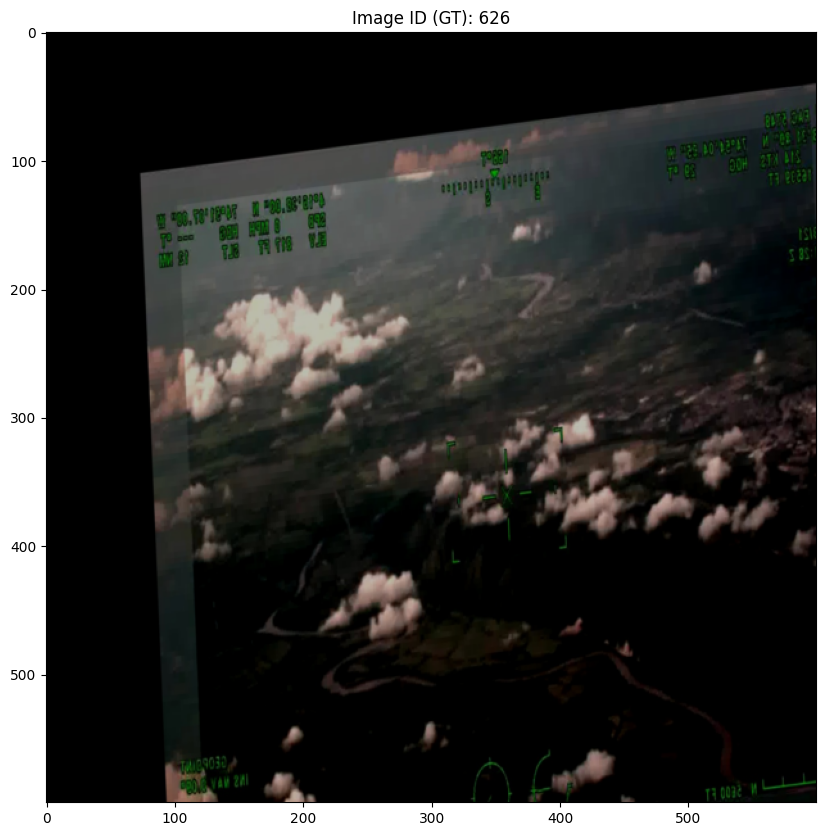

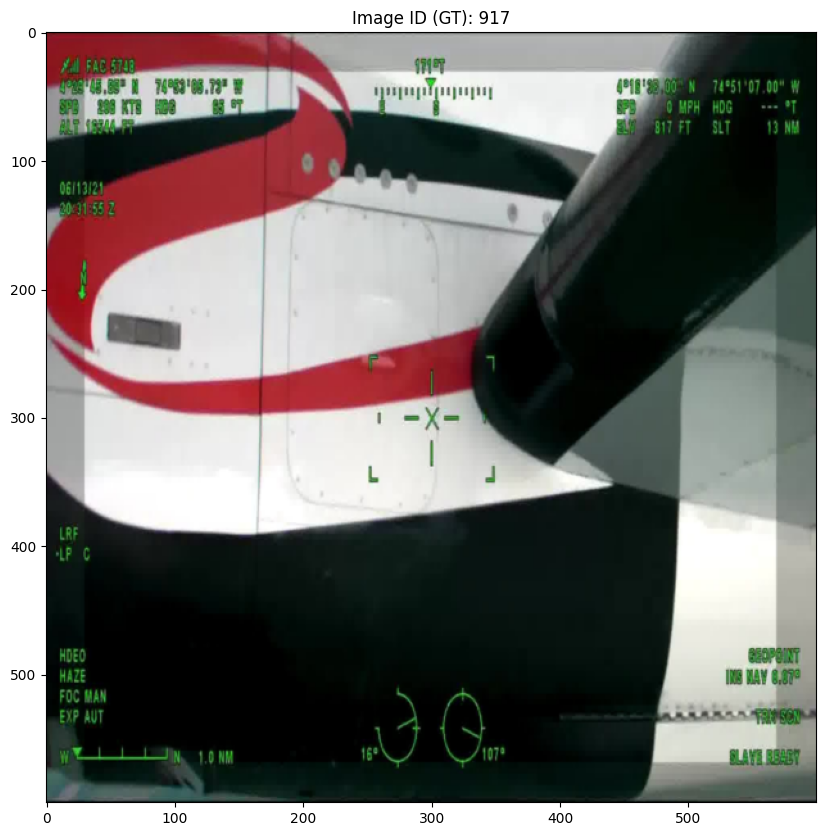

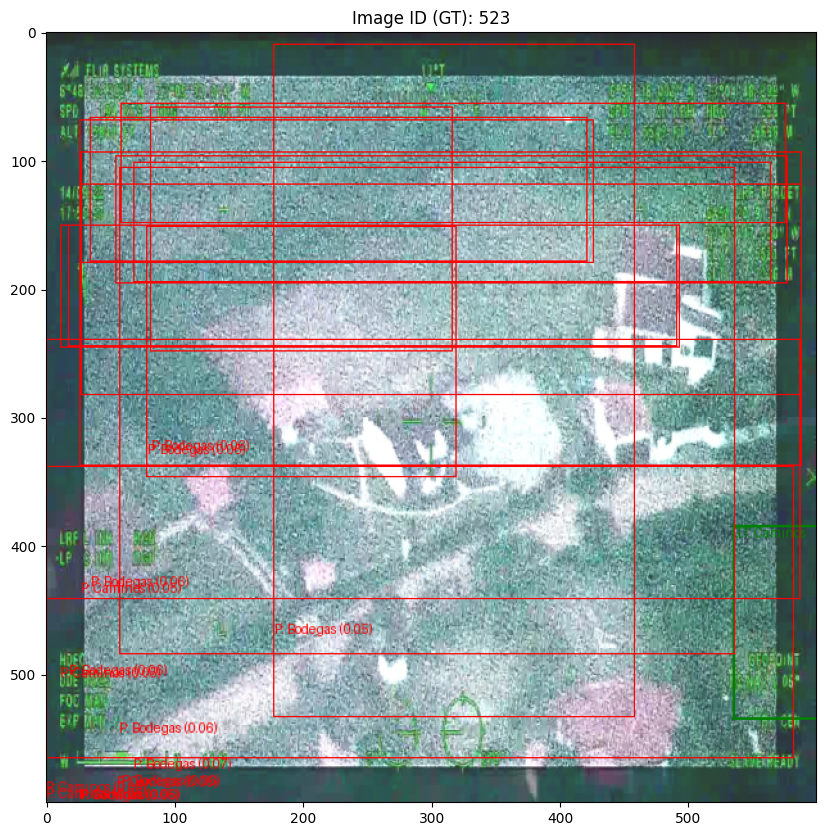

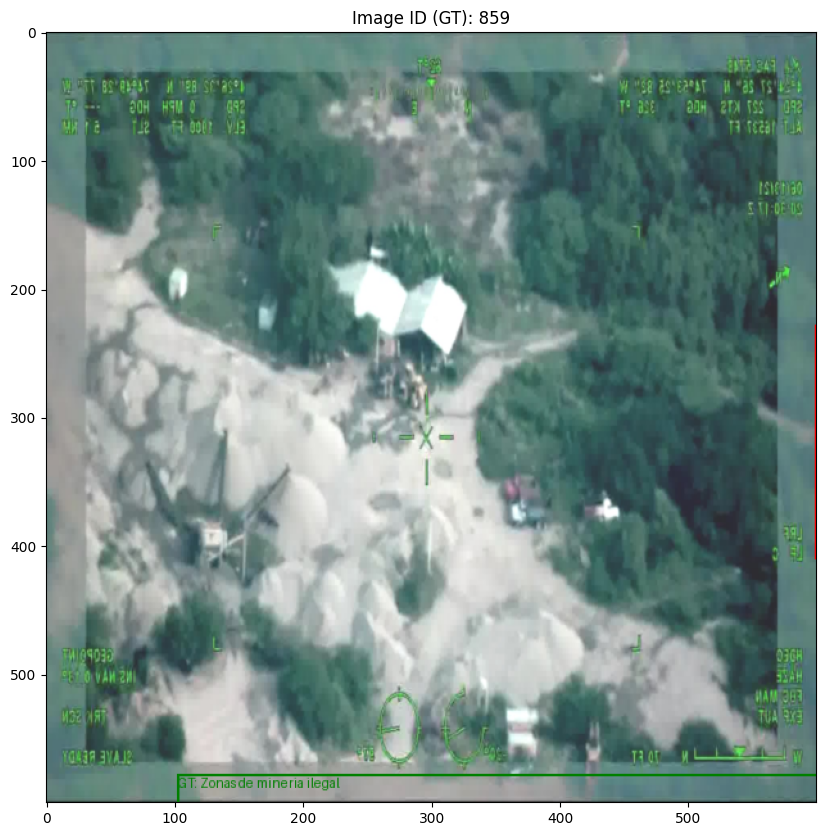

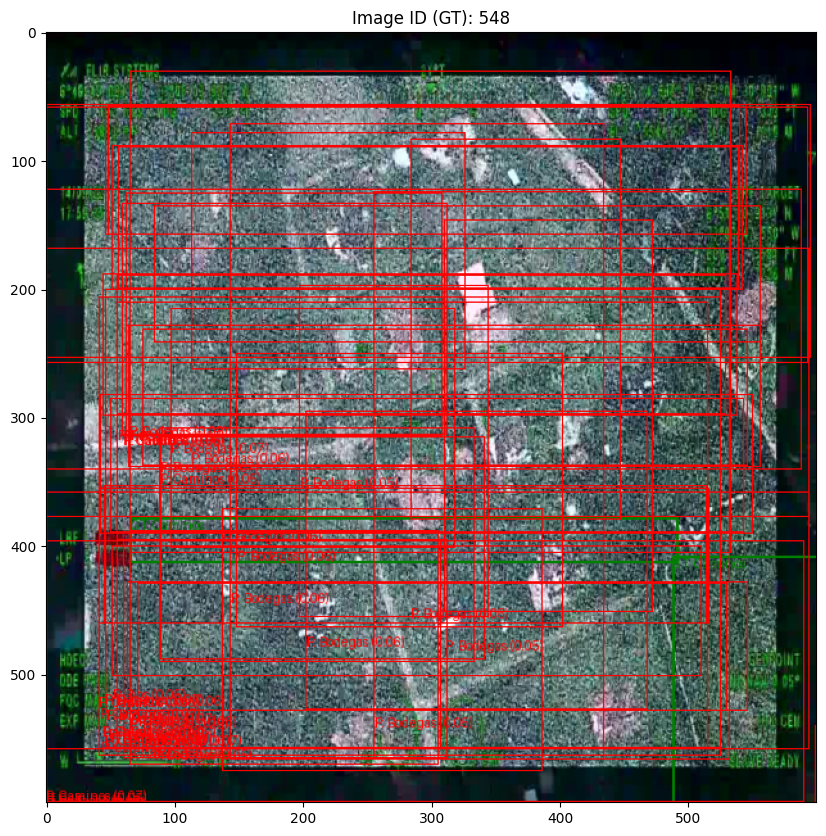

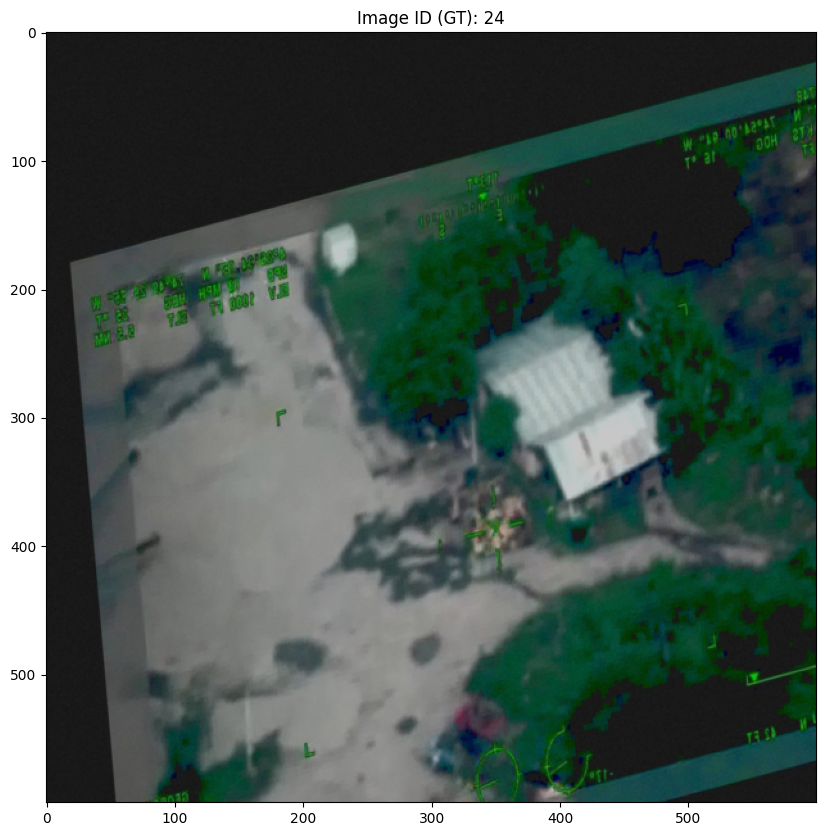

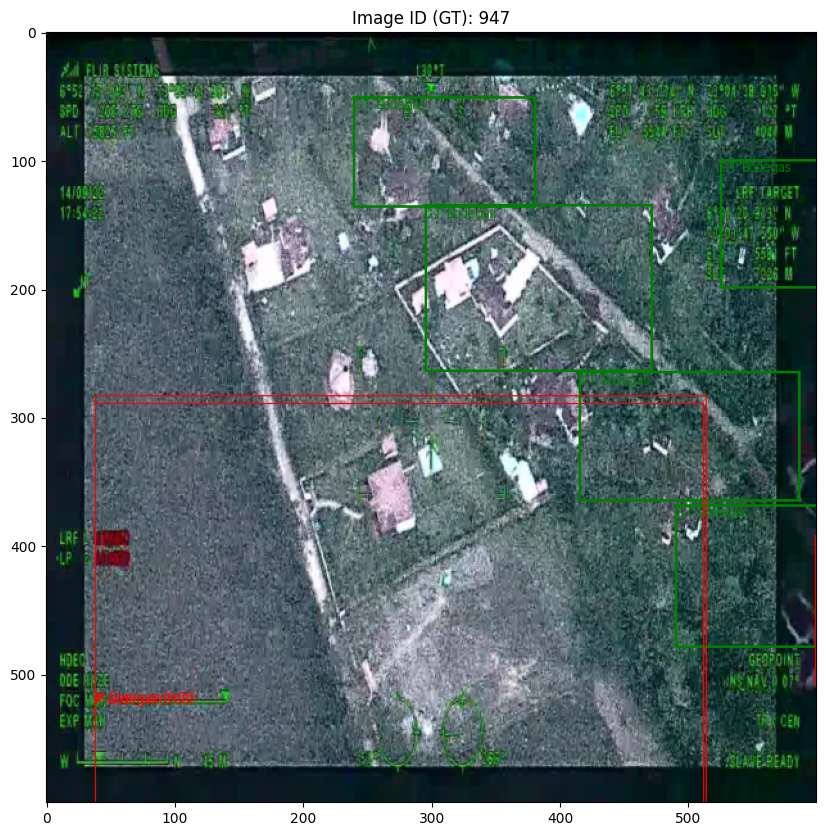

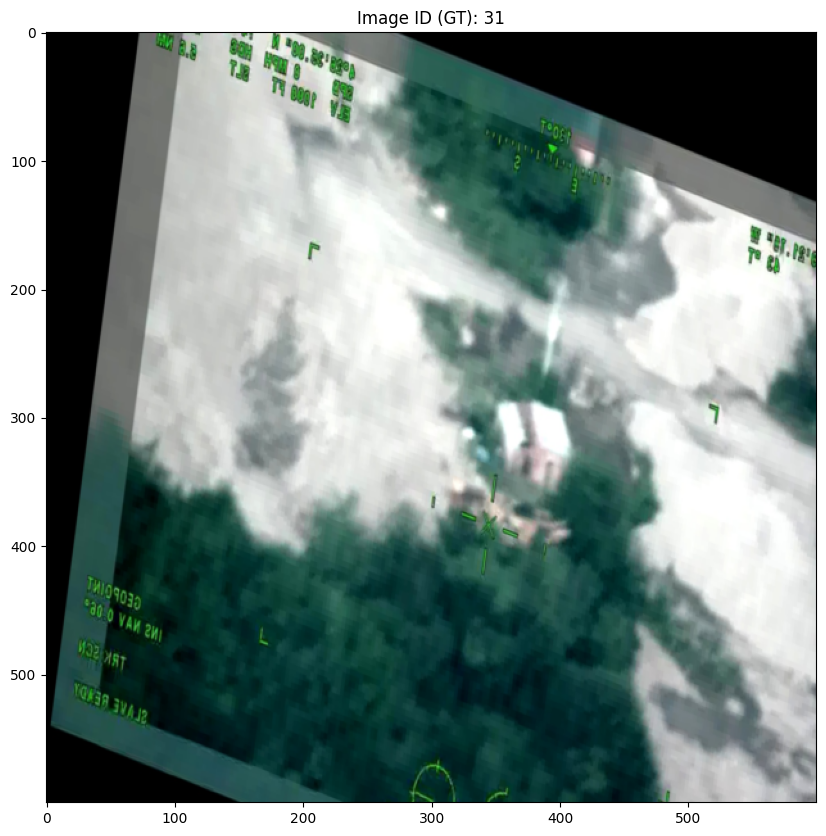

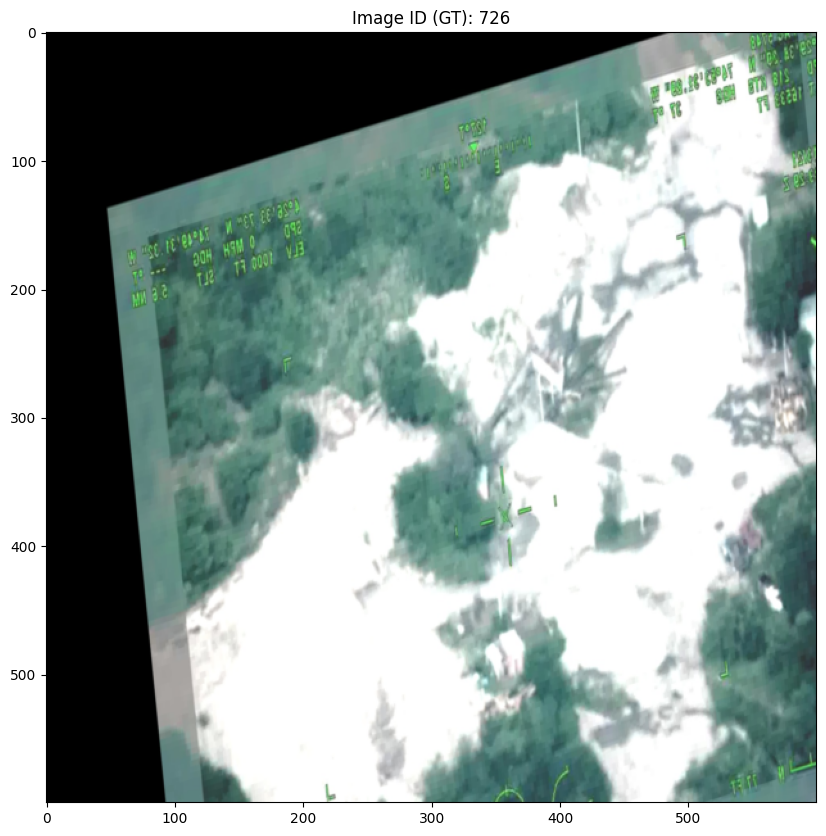

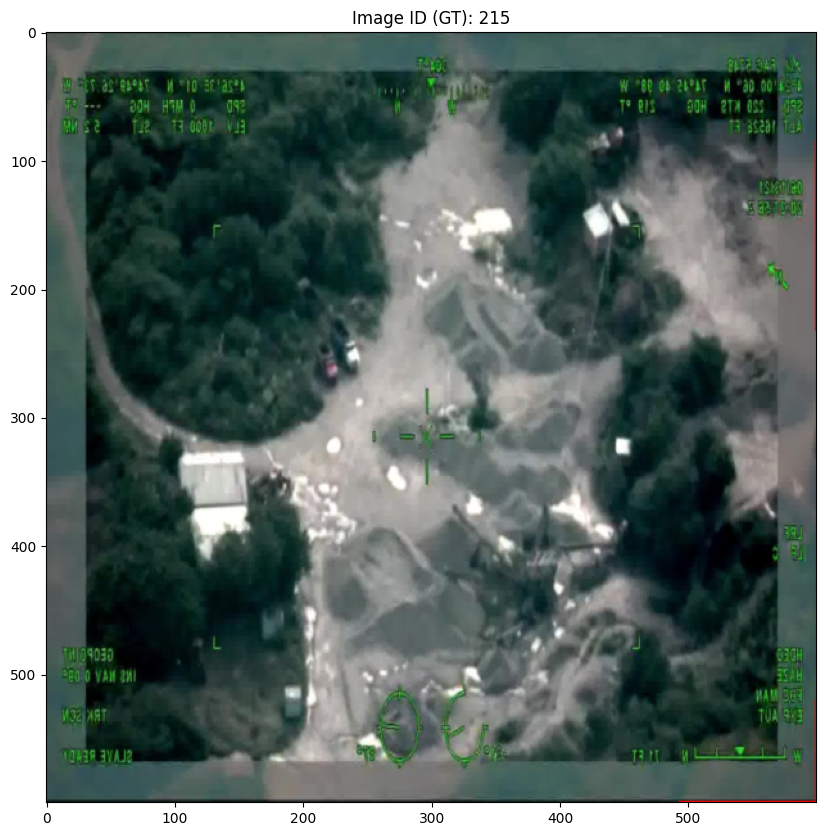

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import ImageDraw

def visualize_predictions(model, data_loader, device, num_images=4, score_threshold=0.001):
    model.eval()
    count = 0
    # Necesitamos el dataset original para obtener la ruta de la imagen si usamos Subset
    original_dataset = data_loader.dataset
    if isinstance(original_dataset, torch.utils.data.Subset):
        original_dataset = original_dataset.dataset

    for images, targets in data_loader:
        if count >= num_images:
            break

        images_gpu = [img.to(device) for img in images] # Mover solo la imagen actual al dispositivo
        with torch.no_grad():
            outputs = model(images_gpu)

        # Procesar la primera imagen del batch para visualización
        img_pil = T.ToPILImage()(images[0].cpu()) # Convertir tensor a PIL para dibujar
        draw = ImageDraw.Draw(img_pil)

        # Dibujar Ground Truth
        for box, label_idx in zip(targets[0]['boxes'], targets[0]['labels']):
            # label_idx es el ID del modelo (1-idx)
            coco_gt_id = MODEL_ID_TO_COCO_ID.get(label_idx.item(), "N/A")
            class_name_gt = CLASS_NAMES_COCO.get(coco_gt_id, "Desconocido_GT")
            draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="green", width=2)
            draw.text((box[0], box[1]), f"GT: {class_name_gt}", fill="green")

        # Dibujar Predicciones
        output = outputs[0] # Para la primera imagen del batch
        for box, label, score in zip(output['boxes'].cpu(), output['labels'].cpu(), output['scores'].cpu()):
            if score > score_threshold:
                coco_pred_id = MODEL_ID_TO_COCO_ID.get(label.item(), "N/A")
                class_name_pred = CLASS_NAMES_COCO.get(coco_pred_id, "Desconocido_Pred")
                draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=1)
                draw.text((box[0], box[2]), f"P: {class_name_pred} ({score:.2f})", fill="red")

        plt.figure(figsize=(10, 10))
        plt.imshow(img_pil)
        plt.title(f"Image ID (GT): {targets[0]['image_id'].item()}")
        plt.show()
        count += 1
    ##model.train() # Volver a modo entrenamiento si es necesario después

# Llama a esto después de tu bucle de entrenamiento (o después de algunas épocas)
# print("\n--- Visualizando algunas predicciones de validación ---")
visualize_predictions(model, data_loader_val, DEVICE, num_images=10, score_threshold=0.001)